<a href="https://colab.research.google.com/github/gitHubAndyLee2020/TF_Image_Classification_Projects/blob/main/Stanford_Dog_Breed_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up and Data Cleaning

In [1]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-08-23 09:54:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-23 09:54:23 (76.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [69]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="stanford_dogs",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [7]:
len(train_data), len(test_data)

(12000, 8580)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

In [10]:
class_names = ds_info.features["label"].names
class_names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [11]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (500, 333, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: 36
  Class name: n02094433-yorkshire_terrier
  


In [13]:
image

<tf.Tensor: shape=(500, 333, 3), dtype=uint8, numpy=
array([[[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [19, 17, 20],
        [19, 17, 20],
        [19, 17, 20]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [19, 17, 20],
        [19, 17, 20],
        [19, 17, 20]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [19, 17, 20],
        [19, 17, 20],
        [19, 17, 20]],

       ...,

       [[19, 19, 19],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [23, 21, 22],
        [24, 22, 23],
        [24, 22, 23]],

       [[19, 19, 19],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [22, 20, 21],
        [22, 20, 21],
        [23, 21, 22]],

       [[19, 19, 19],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [21, 19, 20],
        [21, 19, 20],
        [22, 20, 21]]], dtype=uint8)>

In [15]:
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

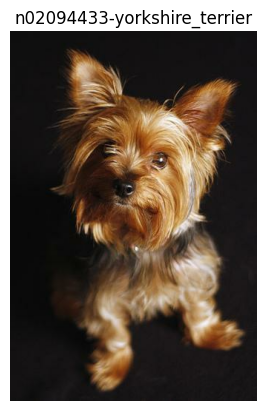

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# Models

In [70]:
from helper_functions import create_tensorboard_callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=0)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              min_lr=1e-7)

In [71]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

In [72]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [73]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

### Feature-Transferring

In [78]:
def create_model():
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = data_augmentation(inputs)
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

model_1 = create_model()
model_1.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [79]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1536)             0         
 ePooling2D)                                                     
                                                                 
 dense_24 (Dense)            (None, 120)               184440    
                                                                 
 softmax_float32 (Activation  (None, 120)              0         
 )                                                               
                                                           

In [80]:
history_1 = model_1.fit(train_data,
                        epochs=3,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)),
                        callbacks=[create_tensorboard_callback("training_logs",
                                                               "model_1"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/model_1/20230823-122055
Epoch 1/3
375/375 [==============================] - 162s 399ms/step - loss: 0.9531 - accuracy: 0.8508 - val_loss: 0.2703 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 2/3
375/375 [==============================] - 140s 374ms/step - loss: 0.2058 - accuracy: 0.9390 - val_loss: 0.2334 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 3/3
375/375 [==============================] - 140s 374ms/step - loss: 0.1444 - accuracy: 0.9561 - val_loss: 0.2292 - val_accuracy: 0.9234 - lr: 0.0010


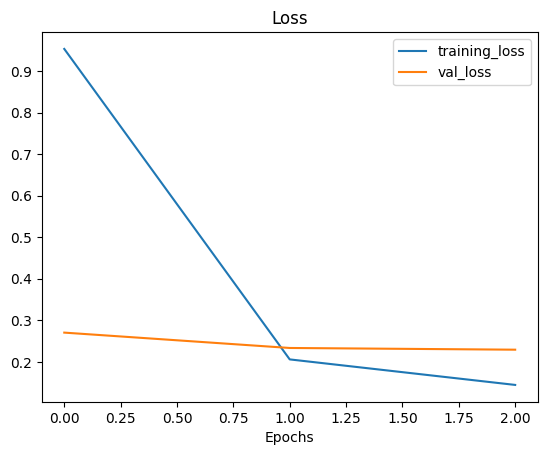

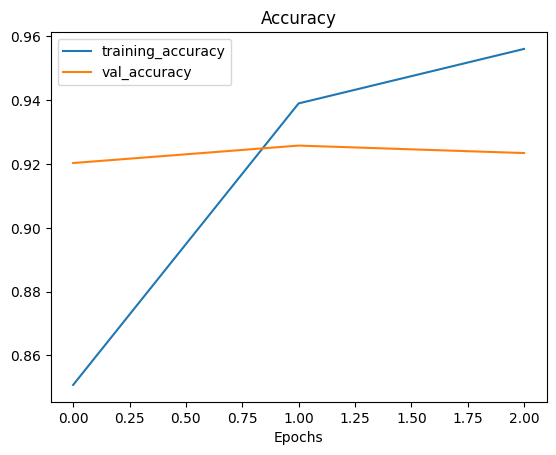

In [81]:
plot_loss_curves(history_1)

In [82]:
pred_1 = model_1.evaluate(test_data)
pred_1[1]

269/269 [==============================] - 90s 333ms/step - loss: 0.2286 - accuracy: 0.9242


0.9242424368858337

In [86]:
save_dir = "model_1"
model_1.save(save_dir)

- Fine-Tuning (all layers)

In [87]:
loaded_model_1 = tf.keras.models.load_model(save_dir)

In [89]:
for layer in loaded_model_1.layers:
  layer.trainable = True

In [96]:
history_loaded_1 = loaded_model_1.fit(train_data,
                                      epochs=10,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs",
                                                                            "loaded_model_1"),
                                                model_checkpoint,
                                                early_stopping,
                                                reduce_lr])

Saving TensorBoard log files to: training_logs/loaded_model_1/20230823-124227
Epoch 1/10
375/375 [==============================] - 155s 382ms/step - loss: 0.1177 - accuracy: 0.9637 - val_loss: 0.2362 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - 141s 375ms/step - loss: 0.0819 - accuracy: 0.9755 - val_loss: 0.2401 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9833
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
375/375 [==============================] - 138s 366ms/step - loss: 0.0607 - accuracy: 0.9833 - val_loss: 0.2374 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - 136s 363ms/step - loss: 0.0428 - accuracy: 0.9907 - val_loss: 0.2351 - val_accuracy: 0.9258 - lr: 2.0000e-04
Epoch 5/10
375/375 [==============================] - 139s 369ms/step - loss: 0.0393 - accuracy: 0.9912 - val_loss: 0.23

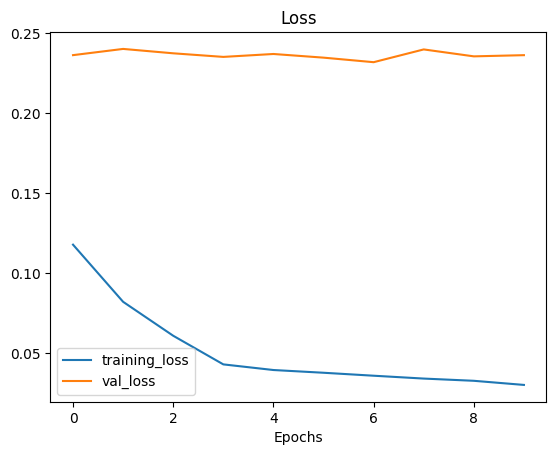

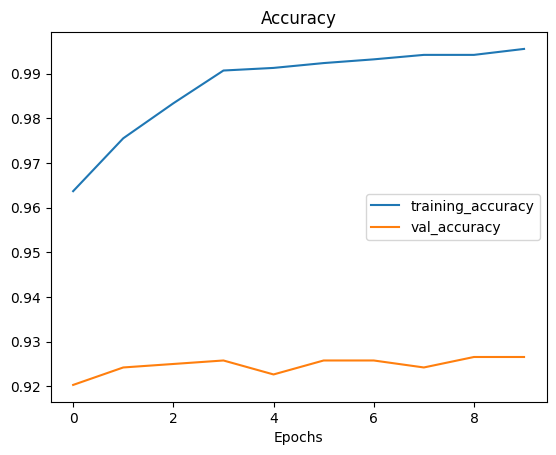

In [98]:
plot_loss_curves(history_loaded_1)

In [97]:
pred_loaded_1 = loaded_model_1.evaluate(test_data)
pred_loaded_1[1]

269/269 [==============================] - 92s 342ms/step - loss: 0.2350 - accuracy: 0.9277


0.9277389049530029

- The val_loss and val_accuracy barely changed as training epochs past, which may indicate overfitting.
- Thus, the next training will only fine-tune the top 10 layers of the base model, reduce the learning rate to 0.0001 (10% of original learning rate), and train for only 5 epochs.

In [99]:
loaded_model_2 = tf.keras.models.load_model(save_dir)

In [100]:
loaded_model_2.compile(loss="sparse_categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=["accuracy"])

In [103]:
for layer in loaded_model_2.layers:
  layer.trainable = True

In [104]:
for layer in loaded_model_2.layers[1].layers[:-10]:
  layer.trainable = False

In [105]:
for layer in loaded_model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b3 True
pooling_layer True
dense_24 True
softmax_float32 True


In [106]:
for layer in loaded_model_2.layers[1].layers:
  print(layer.name, layer.trainable)

input_5 False
rescaling_5 False
normalization_4 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_drop False
block2c_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation F

In [107]:
history_loaded_2 = loaded_model_2.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback("training_logs",
                                                                            "loaded_model_1"),
                                                model_checkpoint,
                                                early_stopping,
                                                reduce_lr])

Saving TensorBoard log files to: training_logs/loaded_model_1/20230823-131927
Epoch 1/5
375/375 [==============================] - 167s 416ms/step - loss: 0.1013 - accuracy: 0.9736 - val_loss: 0.2205 - val_accuracy: 0.9297 - lr: 1.0000e-04
Epoch 2/5
375/375 [==============================] - 147s 390ms/step - loss: 0.0948 - accuracy: 0.9750 - val_loss: 0.2220 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 3/5
375/375 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9762
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
375/375 [==============================] - 152s 405ms/step - loss: 0.0904 - accuracy: 0.9762 - val_loss: 0.2212 - val_accuracy: 0.9297 - lr: 1.0000e-04
Epoch 4/5
375/375 [==============================] - 145s 387ms/step - loss: 0.0849 - accuracy: 0.9785 - val_loss: 0.2205 - val_accuracy: 0.9305 - lr: 2.0000e-05
Epoch 5/5
375/375 [==============================] - 145s 385ms/step - loss: 0.0840 - accuracy: 0.9786 - val_los

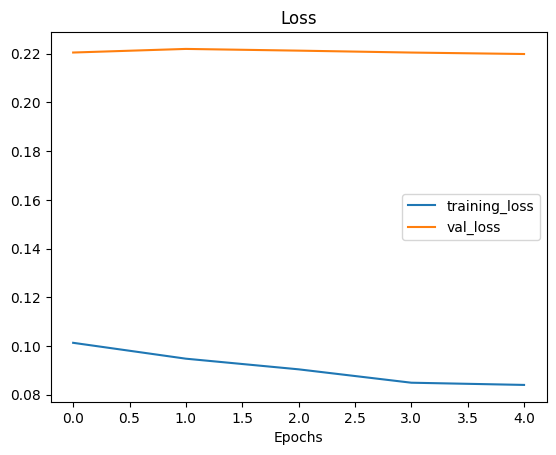

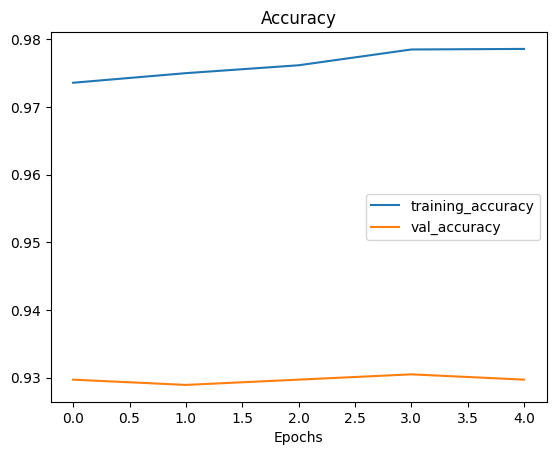

In [108]:
plot_loss_curves(history_loaded_2)

In [109]:
pred_loaded_2 = loaded_model_2.evaluate(test_data)
pred_loaded_2[1]

269/269 [==============================] - 95s 354ms/step - loss: 0.2192 - accuracy: 0.9290


0.9290210008621216

- With a combination of feature transfer and fine-tuning with EfficientNetV2B3 model, the final model achieved 92.9% accuracy.
- The fine-tuning was able to bring the accuracy from 92.4% to 92.9%.